In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, balanced_accuracy_score, ConfusionMatrixDisplay, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)

In [3]:
#from google.colab import files
#uploaded = files.upload()

In [4]:
df = pd.read_parquet('Participants_all.parquet')

In [5]:
df.head()

,pid,window_start,window_end,n_samples,duration_seconds,sex,age_group,label:Walmsley2020,label:Walmsley2020_enc,label:WillettsSpecific2018,label:WillettsSpecific2018_enc,label:WillettsMET2018,label:WillettsMET2018_enc,x_mean,x_std,x_min,x_max,y_mean,y_std,y_min,y_max,z_mean,z_std,z_min,z_max,energy_x,energy_y,energy_z,energy_total,magnitude_mean,corr_xy,corr_xz,corr_yz,fft_dom_freq,fft_peak_power,hour_sin,hour_cos
0,P001,2016-11-13 02:18:00,2016-11-13 02:18:05,500,4.99,1,2,sleep,3,sleep,5,sleep,5,-0.468161,0.004565,-0.482334,-0.46669,-0.537512,0.006892,-0.548902,-0.533341,0.657518,0.003960,0.643077,0.673867,0.219195,0.288966,0.432345,0.940507,0.969787,-0.148480,-0.077644,0.275487,0.4,0.000005,0.566406,0.824126
1,P001,2016-11-13 02:18:05,2016-11-13 02:18:10,500,4.99,1,2,sleep,3,sleep,5,sleep,5,-0.470069,0.006437,-0.482334,-0.46669,-0.537045,0.006771,-0.548902,-0.517780,0.657702,0.003627,0.643077,0.673867,0.221007,0.288463,0.432585,0.942055,0.970582,-0.108382,-0.028882,0.137541,3.6,0.000008,0.566706,0.823920
2,P001,2016-11-13 02:18:10,2016-11-13 02:18:15,500,4.99,1,2,sleep,3,sleep,5,sleep,5,-0.469694,0.006162,-0.482334,-0.46669,-0.537947,0.007104,-0.548902,-0.533341,0.657764,0.003369,0.643077,0.673867,0.220650,0.289438,0.432665,0.942753,0.970944,-0.260468,-0.079268,0.204062,0.4,0.000002,0.567005,0.823714
3,P001,2016-11-13 02:18:15,2016-11-13 02:18:20,500,4.99,1,2,sleep,3,sleep,5,sleep,5,-0.469287,0.005821,-0.482334,-0.46669,-0.537512,0.006962,-0.548902,-0.517780,0.657733,0.003567,0.643077,0.673867,0.220264,0.288967,0.432626,0.941857,0.970483,-0.243211,-0.092415,0.223157,0.4,0.000001,0.567305,0.823508
4,P001,2016-11-13 02:18:20,2016-11-13 02:18:25,500,4.99,1,2,sleep,3,sleep,5,sleep,5,-0.470820,0.006896,-0.482334,-0.46669,-0.535333,0.005291,-0.548902,-0.517780,0.658226,0.002743,0.643077,0.673867,0.221719,0.286609,0.433269,0.941597,0.970350,-0.225457,-0.079250,0.230302,8.8,0.000002,0.567604,0.823302


Aqui eu retirei o participante 1, por ser o que apresenta mais registros, a fim de usar ele no final, para testar o modelo.

In [6]:
df = df[df['pid'] != 'P001']

In [13]:
cols_to_drop = [
    "label:WillettsSpecific2018_enc",
    "label:WillettsMET2018",
    "label:WillettsMET2018_enc",
    "label:WillettsSpecific2018",
    "pid",
    "window_start",
    "window_end",
    "n_samples",
    "duration_seconds",
    "sex","age_group",
    "label:Walmsley2020_enc",
    "label:Walmsley2020",
    "magnitude_mean"

]

X = df.drop(columns=cols_to_drop)
y = df["label:Walmsley2020_enc"]

In [14]:
y.head()

,label:Walmsley2020_enc
37381,3
37382,3
37383,3
37384,3
37385,3


Encontrar pares com correlação maior 1ue 85%, para poder excluí-los do modelo.

In [9]:
corr_matrix = X.corr().abs()

threshold = 0.85

pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
    .rename(columns={0: "correlation"})
)

In [ ]:
high_corr = pairs[pairs["correlation"] >= threshold].sort_values("correlation", ascending=False)

print(high_corr)

In [ ]:
bX = X.drop(columns="magnitude_mean")


In [ ]:
X.head(5)

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(
 #   X, y,
  #  test_size=0.2,
   # random_state=42,
    #stratify=y
#)

In [15]:
rforest = RandomForestClassifier(
    n_estimators=150,
     max_depth=15,
    class_weight="balanced",
    oob_score=True,
    random_state=42,
    n_jobs=-1
)

In [16]:
rforest.fit(X, y)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=150,
                       n_jobs=-1, oob_score=True, random_state=42)

In [17]:
print("OOB Accuracy:", rforest.oob_score_)

OOB Accuracy: 0.852690922235511


In [18]:
oob_pred = rforest.oob_decision_function_.argmax(axis=1)

In [19]:
print("Balanced Accuracy (OOB):", balanced_accuracy_score(y, oob_pred))
print("\nClassification Report (OOB):\n")
print(classification_report(y, oob_pred))

Balanced Accuracy (OOB): 0.8080261361421051

Classification Report (OOB):

              precision    recall  f1-score   support

           0       0.61      0.72      0.66    338775
           1       0.62      0.72      0.67     89016
           2       0.89      0.81      0.85    726132
           3       0.99      0.99      0.99    674688

    accuracy                           0.85   1828611
   macro avg       0.78      0.81      0.79   1828611
weighted avg       0.86      0.85      0.86   1828611



In [20]:
rf_importances = pd.Series(rforest.feature_importances_, index=X.columns).sort_values(ascending=False)
rf_importances.head(20)

,0
hour_cos,0.124910
fft_peak_power,0.114421
x_std,0.113558
z_std,0.110891
y_std,0.101079
hour_sin,0.094300
energy_total,0.069007
fft_dom_freq,0.038221
y_min,0.028696
energy_y,0.028263


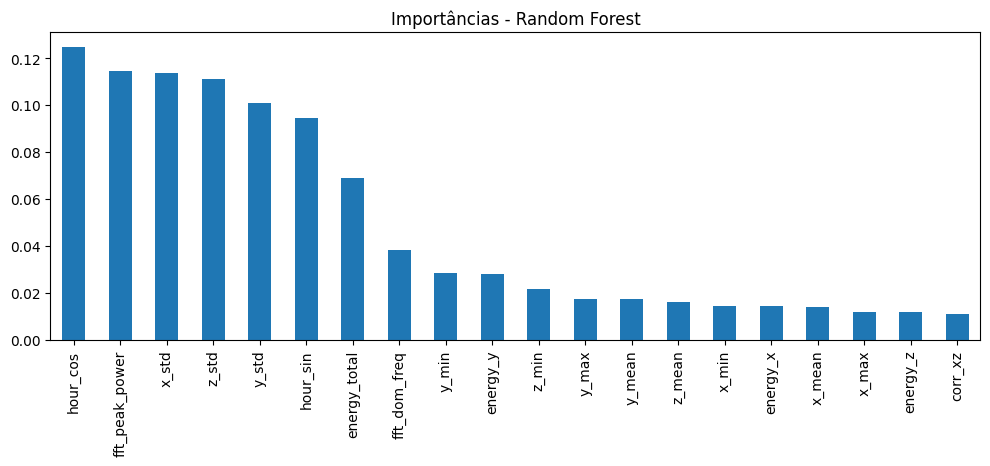

In [21]:
rf_importances.head(20).plot(kind="bar", figsize=(12,4))
plt.title("Importâncias - Random Forest")
plt.show()

<Figure size 800x600 with 0 Axes>

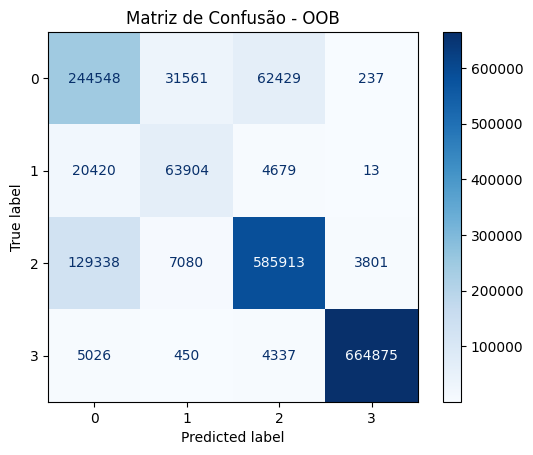

In [22]:
cm = confusion_matrix(y, oob_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=rforest.classes_)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Matriz de Confusão - OOB")
plt.show()

In [23]:
classes = sorted(list(set(y)))

precision = precision_score(y, oob_pred, average=None, labels=classes)
recall    = recall_score(y, oob_pred, average=None, labels=classes)
f1        = f1_score(y, oob_pred, average=None, labels=classes)

class_names = {
    0: "Light",
    1: "Moderate/Vigorous",
    2: "Sedentary",
    3: "Sleep"
}

df_metrics = pd.DataFrame({
    "Classe": classes,
    "Categoria": [class_names[c] for c in classes],
    "Precision": precision,
    "Recall": recall,
    "F1": f1
})

df_metrics

,Classe,Categoria,Precision,Recall,F1
0,0,Light,0.612393,0.721860,0.662636
1,1,Moderate/Vigorous,0.620457,0.717893,0.665629
2,2,Sedentary,0.891315,0.806896,0.847007
3,3,Sleep,0.993944,0.985455,0.989682
